In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json

In [3]:
import pprint

In [4]:

pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-req-build-qq5frdml
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-qq5frdml
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
  Resolved https://github.com/facebookresearch/detectron2.git to commit 82a57ce0b70057685962b352535147d9a8118578
  Preparing metadata (setup.py) ... done


In [5]:
import pandas as pd
import json

In [6]:
import torch
torch.__version__

'1.13.1+cu116'

In [7]:
#!pip install pyyaml==5.1
#!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'


In [8]:
import torch, torchvision
import matplotlib.pyplot as plt
import json
import cv2
import numpy as np
from copy import deepcopy

In [9]:
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures.image_list import ImageList
from detectron2.data import transforms as T
from detectron2.modeling.box_regression import Box2BoxTransform
from detectron2.modeling.roi_heads.fast_rcnn import FastRCNNOutputs
from detectron2.structures.boxes import Boxes
from detectron2.layers import nms
from detectron2 import model_zoo
from detectron2.config import get_cfg

In [10]:
# Load images

In [11]:
df = pd.read_json("/content/drive/MyDrive/data/train.jsonl", lines=True)

In [12]:
df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [13]:
vect_img=df.img
vect_img

0       img/42953.png
1       img/23058.png
2       img/13894.png
3       img/37408.png
4       img/82403.png
            ...      
8495    img/10423.png
8496    img/98203.png
8497    img/36947.png
8498    img/16492.png
8499    img/15937.png
Name: img, Length: 8500, dtype: object

In [14]:
df.img[1]

'img/23058.png'

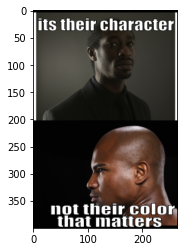

In [15]:
img1 = plt.imread(f'/content/drive/MyDrive/data/img/42953.png')

# Detectron expects BGR images

img_bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
plt.imshow(img1)

plt.show()


In [16]:
img1.shape

(400, 265, 3)

# Load and config model 

In [17]:
cfg_path = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"

def load_config_and_model_weights(cfg_path):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(cfg_path))

    # ROI HEADS SCORE THRESHOLD
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

    # Comment the next line if you're using 'cuda'
    cfg['MODEL']['DEVICE']='cpu'

    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(cfg_path)

    return cfg

cfg = load_config_and_model_weights(cfg_path)

# Load the Object Detection Model

In [18]:
def get_model(cfg):
    # build model
    model = build_model(cfg)

    # load weights
    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    # eval mode
    model.eval()
    return model

model = get_model(cfg)

  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


# Convert Image to Model Input

In [19]:
def prepare_image_inputs(cfg, img_list):
    # Resizing the image according to the configuration
    transform_gen = T.ResizeShortestEdge(
                [cfg.INPUT.MIN_SIZE_TEST, cfg.INPUT.MIN_SIZE_TEST], cfg.INPUT.MAX_SIZE_TEST
            )
    img_list = [transform_gen.get_transform(img).apply_image(img) for img in img_list]

    # Convert to C,H,W format
    convert_to_tensor = lambda x: torch.Tensor(x.astype("float32").transpose(2, 0, 1))

    batched_inputs = [{"image":convert_to_tensor(img), "height": img.shape[0], "width": img.shape[1]} for img in img_list]

    # Normalizing the image
    num_channels = len(cfg.MODEL.PIXEL_MEAN)
    pixel_mean = torch.Tensor(cfg.MODEL.PIXEL_MEAN).view(num_channels, 1, 1)
    pixel_std = torch.Tensor(cfg.MODEL.PIXEL_STD).view(num_channels, 1, 1)
    normalizer = lambda x: (x - pixel_mean) / pixel_std
    images = [normalizer(x["image"]) for x in batched_inputs]

    # Convert to ImageList
    images =  ImageList.from_tensors(images,model.backbone.size_divisibility)
    
    return images, batched_inputs


In [20]:
images, batched_inputs = prepare_image_inputs(cfg, [img_bgr1])
#Batch c'est le vecteur des images

# Get ResNet+FPN features

In [21]:
def get_features(model, images):
    features = model.backbone(images.tensor)
    return features


In [22]:
features = get_features(model, images)

In [23]:
features

{'p2': tensor([[[[-7.6884e-01,  2.2289e-01,  2.8646e-01,  ...,  2.2229e+00,
             3.2982e+00,  3.7129e+00],
           [-1.8920e+00, -1.4970e+00, -1.7439e+00,  ...,  6.3898e-01,
             1.8191e+00,  3.9280e+00],
           [-1.4282e+00, -1.4981e+00, -2.3036e+00,  ..., -1.8273e-01,
             1.1391e+00,  3.4744e+00],
           ...,
           [ 2.7107e+00,  4.6748e+00,  3.7368e+00,  ...,  6.4809e+00,
             8.3787e+00,  7.1518e+00],
           [-1.1954e+00,  9.6143e-01,  3.5866e-01,  ...,  3.0829e+00,
             3.8203e+00,  5.6512e+00],
           [-2.6680e+00, -3.3200e+00, -3.1951e+00,  ..., -1.1938e+00,
            -1.3392e+00,  1.3153e+00]],
 
          [[-2.1535e+00, -5.3653e-01, -2.1211e-01,  ..., -8.9365e-01,
            -8.1875e-01, -4.0931e-01],
           [-3.2599e+00, -1.1866e+00, -4.5432e-01,  ..., -4.6835e-01,
            -5.6765e-01, -2.3317e-01],
           [-2.9666e+00, -1.3972e+00, -3.2839e-01,  ..., -3.8537e-01,
            -3.9264e-01, -1.6093e

# Visualizing Image and Image features

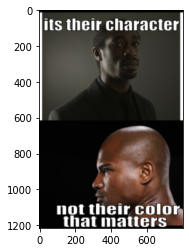

torch.Size([1, 256, 304, 200])


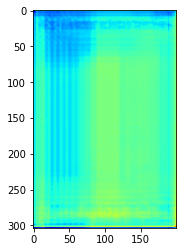

torch.Size([1, 256, 152, 100])


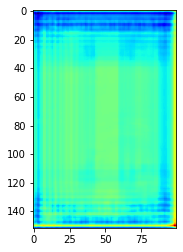

torch.Size([1, 256, 76, 50])


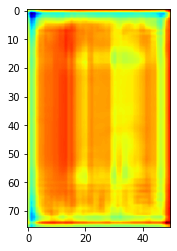

torch.Size([1, 256, 38, 25])


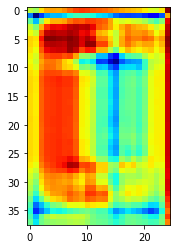

torch.Size([1, 256, 19, 13])


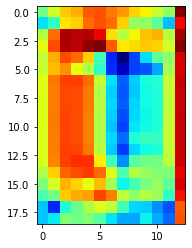

In [24]:
plt.imshow(cv2.resize(img1, (images.tensor.shape[-2:][::-1])))
plt.show()
for key in features.keys():
    print(features[key].shape)
    plt.imshow(features[key][0,0,:,:].squeeze().detach().numpy(), cmap='jet')
    plt.show()

# Get region proposals from RPN

In [25]:
def get_proposals(model, images, features):
    proposals, _ = model.proposal_generator(images, features)
    return proposals

proposals = get_proposals(model, images, features)

/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Get box features


In [26]:
def get_box_features(model, features, proposals):
    features_list = [features[f] for f in ['p2', 'p3', 'p4', 'p5']]
    box_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    box_features = model.roi_heads.box_head.flatten(box_features)
    box_features = model.roi_heads.box_head.fc1(box_features)
    box_features = model.roi_heads.box_head.fc_relu1(box_features)
    box_features = model.roi_heads.box_head.fc2(box_features)

    box_features = box_features.reshape(1,1000,1024) # depends on your config and batch size
    return box_features, features_list

In [27]:
box_features, features_list = get_box_features(model, features, proposals)

# Get prediction logits and boxes

In [28]:
def get_prediction_logits(model, features_list, proposals):
    cls_features = model.roi_heads.box_pooler(features_list, [x.proposal_boxes for x in proposals])
    cls_features = model.roi_heads.box_head(cls_features)
    pred_class_logits, pred_proposal_deltas = model.roi_heads.box_predictor(cls_features)
    return pred_class_logits, pred_proposal_deltas

pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)

# Get FastRCNN scores and boxes

In [29]:
def get_box_scores(cfg, pred_class_logits, pred_proposal_deltas):
    box2box_transform = Box2BoxTransform(weights=cfg.MODEL.ROI_BOX_HEAD.BBOX_REG_WEIGHTS)
    smooth_l1_beta = cfg.MODEL.ROI_BOX_HEAD.SMOOTH_L1_BETA

    outputs = FastRCNNOutputs(
        box2box_transform,
        pred_class_logits,
        pred_proposal_deltas,
        proposals,
        smooth_l1_beta,
    )

    boxes = outputs.predict_boxes()
    scores = outputs.predict_probs()
    image_shapes = outputs.image_shapes

    return boxes, scores, image_shapes

boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)

# Rescale the boxes to original image size

In [30]:
def get_output_boxes(boxes, batched_inputs, image_size):
    proposal_boxes = boxes.reshape(-1, 4).clone()
    scale_x, scale_y = (batched_inputs["width"] / image_size[1], batched_inputs["height"] / image_size[0])
    output_boxes = Boxes(proposal_boxes)

    output_boxes.scale(scale_x, scale_y)
    output_boxes.clip(image_size)

    return output_boxes

output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]

# Select the Boxes using NMS

In [31]:
def select_boxes(cfg, output_boxes, scores):
    test_score_thresh = cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST
    test_nms_thresh = cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST
    cls_prob = scores.detach()
    cls_boxes = output_boxes.tensor.detach().reshape(1000,80,4)
    max_conf = torch.zeros((cls_boxes.shape[0]))
    for cls_ind in range(0, cls_prob.shape[1]-1):
        cls_scores = cls_prob[:, cls_ind+1]
        det_boxes = cls_boxes[:,cls_ind,:]
        keep = np.array(nms(det_boxes, cls_scores, test_nms_thresh))
        max_conf[keep] = torch.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])
    keep_boxes = torch.where(max_conf >= test_score_thresh)[0]
    return keep_boxes, max_conf

In [32]:
temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]
keep_boxes, max_conf = [],[]
for keep_box, mx_conf in temp:
    keep_boxes.append(keep_box)
    max_conf.append(mx_conf)

# Limit the total number of boxes

In [33]:
MIN_BOXES=10
MAX_BOXES=100
def filter_boxes(keep_boxes, max_conf, min_boxes, max_boxes):
    if len(keep_boxes) < min_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:min_boxes]
    elif len(keep_boxes) > max_boxes:
        keep_boxes = np.argsort(max_conf).numpy()[::-1][:max_boxes]
    return keep_boxes

keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]

# Get the visual embeddings :

In [34]:
def get_visual_embeds(box_features, keep_boxes):
    return box_features[keep_boxes.copy()]

visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]

In [35]:
visual_embeds

[tensor([[-1.5151, -1.3061,  0.4343,  ..., -1.0215,  0.6716,  0.3357],
         [-1.5709, -1.1686,  0.5398,  ..., -1.6218,  0.0985, -0.2234],
         [-1.8066, -1.1910,  0.3168,  ..., -1.1237,  0.5533,  0.1434],
         ...,
         [-1.7307, -0.8541, -0.9089,  ..., -1.5051, -0.2767, -0.3054],
         [ 0.1948, -0.7817,  1.0357,  ..., -0.2046,  0.0073,  0.9983],
         [ 1.2156, -1.0004,  0.5880,  ..., -0.4656, -0.0065,  0.9104]],
        grad_fn=<IndexBackward0>)]

# Generalisation

In [36]:
def concatenation_visual_embeded(img1): 
    img_bgr1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
    images, batched_inputs = prepare_image_inputs(cfg, [img_bgr1])
    features = get_features(model, images)
    proposals = get_proposals(model, images, features)
    box_features, features_list = get_box_features(model, features, proposals)
    pred_class_logits, pred_proposal_deltas = get_prediction_logits(model, features_list, proposals)
    boxes, scores, image_shapes = get_box_scores(cfg, pred_class_logits, pred_proposal_deltas)
    output_boxes = [get_output_boxes(boxes[i], batched_inputs[i], proposals[i].image_size) for i in range(len(proposals))]
    temp = [select_boxes(cfg, output_boxes[i], scores[i]) for i in range(len(scores))]

    keep_boxes, max_conf = [],[]
    for keep_box, mx_conf in temp:
        keep_boxes.append(keep_box)
        max_conf.append(mx_conf)
        
    keep_boxes = [filter_boxes(keep_box, mx_conf, MIN_BOXES, MAX_BOXES) for keep_box, mx_conf in zip(keep_boxes, max_conf)]
    
    visual_embeds = [get_visual_embeds(box_feature, keep_box) for box_feature, keep_box in zip(box_features, keep_boxes)]
    
    return visual_embeds

In [37]:
a = concatenation_visual_embeded(img1)

In [38]:
type(a[0])

torch.Tensor

In [43]:
import json
import pickle
df = pd.read_json("/content/drive/MyDrive/data/train.jsonl", lines=True)


In [44]:
l1 = []

with open("/content/drive/MyDrive/data/file.pkl", "rb") as f:
    l1 = pickle.load(f)
f.close()
print(len(l1))

8500


In [45]:
l = l1

In [47]:
i = len(l) 

In [48]:

print(i)
while i < 8500 :  
   # if i != 282 and i != 344 and i != 361 and i != 944 and i != 976 and i != 1054 and i != 1454 and i != 1651 and i != 1706 and i != 1962 and i != 2203 and i!= 2299:
    if i not in [282, 344, 361, 944, 976, 1054, 1454, 1651, 1706, 1962, 2203, 2299, 2685, 2827, 2986, 3599, 3803,4072, 4122, 4203, 4701, 5245, 5248, 5463, 5567, 5804, 6331, 6413, 6487, 6581, 6610, 7000, 7262, 8182, 8195, 8225]: 
      img = plt.imread(f'/content/drive/MyDrive/data/' + df.img[i]) 
      con = concatenation_visual_embeded(img)[0].detach().numpy()
      l.append(con)
    else:
      l.append(0)
    i+=1


8498


In [49]:

#l.pop()
with open("/content/drive/MyDrive/data/file.pkl", "wb") as f:
    pickle.dump(l, f)
f.close()

In [46]:
df.loc[:, 'embedded'] = l

In [ ]:
df.to_json(path_or_buf = "D:\code\2ème année\statsapp\data\train_embed.jsonl", orient = 'records', lines = True)

# Entrainement du model 

In [ ]:
df